In [49]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

In [50]:
class Result:
  def __init__(self):
    self.min_cost = float('inf')

class findPath:

  def brute_force_dfs(self, spot, n, graph, visited, cost, result):
    if len(visited) == n:
      result.min_cost = min(result.min_cost, cost)
      return

    for next_spot in graph[spot]:
      if next_spot in visited:
        continue
    visited.add(next_spot)
    self.brute_force_dfs(next_spot, n, graph, visited, cost + graph[spot][next_spot], result)
    visited.remove(next_spot)

  def minCost(n, mcd, list_of_intersection):
    graph = self.construct_graph(list_of_intersection)
    result = Result()
    n = len(list_of_intersection)
    self.brute_force_dfs(mcd, n, graph, set(mcd), 0, result)

  # def prunning_dfs(self, spot, n, graph, visited, cost, result)

  # def dp_findPath(self, graph, list_of_intersection, mcd)


In [51]:
class Node:
    def __init__(self):
        self.isVisited = False
        self.hasMCD = False
        self.neighbors = list()
        self.MCDRegion = (-1,-1)
        self.color = [255,255,255]

    def __repr__(self):
        return '(McD: {} isVisited: {} regionalMcD: {})'.format(self.hasMCD, self.isVisited, self.MCDRegion)

In [52]:
class Grid:
  def __init__(self, streets=228, aves=13):
    self.streets = streets
    self.aves = aves
    self.grid = [[Node() for y in range(aves)] for x in range(streets)]

  def draw_map(self):
    r = ''
    for x in range(self.streets):
      r += f'{x}: '
      for y in range(self.aves):
        if self.grid[x][y].hasMCD:
            r += f'[{self.grid[x][y].hasMCD}] '
        else:
            r += f'[{self.grid[x][y].MCDRegion}] '
      r += '\n'
    return r
  
  def __repr__(self):
    return self.draw_map()

In [53]:
import random
def rand_color():
    return [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]

In [54]:
McD_loc = "McDonald_loc.txt"

In [55]:
with open(McD_loc) as f:
    mcd_loc_data = []
    for line in f:
        s = line.split(",")
        s[0] = int(s[0])
        s[1] = int(s[1])
        s.append(rand_color())
        mcd_loc_data.append(s)

In [56]:
MD_loc_data = pd.DataFrame(mcd_loc_data,columns=['SN_Street', 'EW_Avenue', 'Inter_Names', 'Color'])
MD_loc_data.head()

,SN_Street,EW_Avenue,Inter_Names,Color
0,11,5,MaidenLn+Broadway\n,"[130, 253, 56]"
1,19,6,Chambers+Greenwich\n,"[207, 11, 191]"
2,28,4,Canel+Lafayette\n,"[171, 201, 164]"
3,32,1,Williamsburg+Essex\n,"[212, 28, 220]"
4,35,7,Houston+Varick\n,"[237, 136, 117]"


Description of features:
'SN_Street': We assign street numbers from 1 to 228 from south to north of Manhattan
'EW_Avenue': We assign avenue numbers from 1 to 13 from east to north of Manhattan
'Inter_Names': The name of two streets that have a McDonald's in their intersection

In [57]:
map = Grid()

In [58]:
print(map.grid[0][0])

(McD: False isVisited: False regionalMcD: (-1, -1))


In [59]:
color_mapping = {}

In [60]:
for index, row in MD_loc_data.iterrows():
    st, ave = int(row['SN_Street']) - 1, int(row['EW_Avenue']) - 1
    map.grid[st][ave].hasMCD = True
    color_mapping[(st, ave)] = row['Color']

In [61]:
def calc_euclidean(pos1x, pos1y, pos2x, pos2y):
    return math.sqrt((pos2x - pos1x)**2 + (pos2y - pos1y)**2)

def calc_manhattan(pos1x, pos1y, pos2x, pos2y):
    return abs(pos2x - pos1x) + abs(pos2y - pos1y)

In [62]:
for i in range(len(map.grid)):
    for j in range(len(map.grid[0])):
        min_dis = float('inf')
        for index, row in MD_loc_data.iterrows():
            st, ave = int(row['SN_Street']) - 1, int(row['EW_Avenue']) - 1
            dis = calc_manhattan(i, j, st, ave)
            if dis < min_dis:
                min_dis = dis
                map.grid[i][j].MCDRegion = (st, ave)
                if map.grid[i][j].hasMCD:
                    map.grid[i][j].color = [0, 0, 0]
                else:
                    map.grid[i][j].color = color_mapping[(st, ave)]

In [63]:
map.grid[0][0].color

[130, 253, 56]

In [64]:
from PIL import Image

def make_colors(map, scale=8):
    data = np.zeros((map.streets * scale, map.aves * scale, 3), dtype=np.uint8)
    for i in range(map.streets):
        for j in range(map.aves):
            for k in range(scale):
                for l in range (scale):
                    data[scale*i + k, scale*j + l] = map.grid[i][j].color

    return Image.fromarray(data).transpose(method=Image.ROTATE_180)

In [65]:
c = make_colors(map)

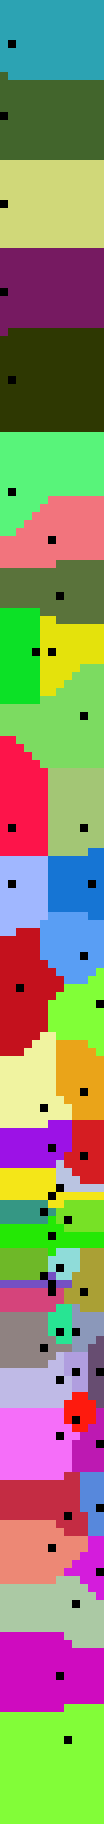

In [66]:
display(c) #jupyter command

In [67]:
c.save('manhattanmcd.png', format=None)

In [68]:
def assign_points(map, prob=0.10):
    locations = []
    for i in range(map.streets):
        for j in range(map.aves):
            if random.random() <= prob:
                locations.append((i, j))
    return locations

In [69]:
delivery_loc = assign_points(map)

In [70]:
#separate locations by McDRegion buckets
def regionize(locations, map):
    regionpoints = {}
    for point in locations:
        i, j = point[0], point[1]
        region = map.grid[i][j].MCDRegion
        if region not in regionpoints:
            regionpoints[region] = []
            regionpoints[region].append(region)
            regionpoints[region].append(point)
        else:
            regionpoints[region].append(point)
    return regionpoints

In [71]:
loc = regionize(delivery_loc, map)

In [72]:
loc

{(10, 4): [(10, 4),
  (3, 10),
  (4, 3),
  (4, 5),
  (5, 7),
  (6, 1),
  (7, 2),
  (10, 4),
  (10, 6),
  (12, 1),
  (12, 4),
  (13, 7),
  (13, 8),
  (13, 12),
  (14, 2)],
 (18, 5): [(18, 5),
  (15, 11),
  (15, 12),
  (17, 6),
  (18, 10),
  (19, 7),
  (19, 11),
  (19, 12),
  (21, 2),
  (21, 7),
  (22, 6),
  (23, 6)],
 (27, 3): [(27, 3),
  (24, 0),
  (24, 2),
  (24, 12),
  (27, 2),
  (27, 8),
  (27, 10),
  (27, 11),
  (29, 6),
  (29, 11)],
 (34, 6): [(34, 6), (32, 11), (33, 4), (33, 9), (35, 4), (36, 8)],
 (31, 0): [(31, 0), (33, 1), (34, 1), (35, 0)],
 (38, 4): [(38, 4), (36, 3), (37, 5), (38, 8), (39, 8), (40, 6), (40, 11)],
 (39, 0): [(39, 0), (40, 2), (41, 2)],
 (47, 0): [(47, 0), (45, 2), (48, 1)],
 (48, 5): [(48, 5),
  (45, 12),
  (46, 8),
  (49, 4),
  (49, 11),
  (51, 6),
  (51, 9),
  (51, 10)],
 (50, 3): [(50, 3), (50, 1), (53, 3)],
 (55, 5): [(55, 5), (52, 12), (54, 7), (57, 5)],
 (59, 7): [(59, 7), (58, 12), (59, 10), (60, 12), (61, 12), (63, 9)],
 (61, 3): [(61, 3), (59, 3), (

In [73]:
def calc_manhattan(p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

In [74]:
pip install landscapes

Note: you may need to restart the kernel to use updated packages.


In [75]:
import time
runtimes = {}

In [76]:
loc

{(10, 4): [(10, 4),
  (3, 10),
  (4, 3),
  (4, 5),
  (5, 7),
  (6, 1),
  (7, 2),
  (10, 4),
  (10, 6),
  (12, 1),
  (12, 4),
  (13, 7),
  (13, 8),
  (13, 12),
  (14, 2)],
 (18, 5): [(18, 5),
  (15, 11),
  (15, 12),
  (17, 6),
  (18, 10),
  (19, 7),
  (19, 11),
  (19, 12),
  (21, 2),
  (21, 7),
  (22, 6),
  (23, 6)],
 (27, 3): [(27, 3),
  (24, 0),
  (24, 2),
  (24, 12),
  (27, 2),
  (27, 8),
  (27, 10),
  (27, 11),
  (29, 6),
  (29, 11)],
 (34, 6): [(34, 6), (32, 11), (33, 4), (33, 9), (35, 4), (36, 8)],
 (31, 0): [(31, 0), (33, 1), (34, 1), (35, 0)],
 (38, 4): [(38, 4), (36, 3), (37, 5), (38, 8), (39, 8), (40, 6), (40, 11)],
 (39, 0): [(39, 0), (40, 2), (41, 2)],
 (47, 0): [(47, 0), (45, 2), (48, 1)],
 (48, 5): [(48, 5),
  (45, 12),
  (46, 8),
  (49, 4),
  (49, 11),
  (51, 6),
  (51, 9),
  (51, 10)],
 (50, 3): [(50, 3), (50, 1), (53, 3)],
 (55, 5): [(55, 5), (52, 12), (54, 7), (57, 5)],
 (59, 7): [(59, 7), (58, 12), (59, 10), (60, 12), (61, 12), (63, 9)],
 (61, 3): [(61, 3), (59, 3), (

In [77]:
costs = 0
for key in loc:
    points = loc[key]
    mode_cost = 0
    for i in range(len(points) - 1):
        mode_cost += calc_manhattan(points[i], points[i + 1])
    costs += mode_cost

In [78]:
costs

1257

## Simulated Annealing Implementation

In [79]:

from landscapes.single_objective import tsp

import pandas as pd
# import osmnx as ox
import networkx as nx
import math
import random

In [80]:
tsp_manhattan = tsp(dist_func=calc_manhattan, close_loop=True).dist

In [81]:
tsp_manhattan(delivery_loc)

1694

In [82]:
from random import randint
from random import random
from math import exp
from math import log
class minimize():
    '''Simple Simulated Annealing
    '''

    def __init__(self, func, x0, opt_mode, cooling_schedule='linear', step_max=1000, t_min=0, t_max=100, bounds=[], alpha=None, damping=1):

        # checks
        assert opt_mode in ['combinatorial','continuous'], 'opt_mode must be either "combinatorial" or "continuous"'
        assert cooling_schedule in ['linear','exponential','logarithmic', 'quadratic'], 'cooling_schedule must be either "linear", "exponential", "logarithmic", or "quadratic"'


        # initialize starting conditions
        self.t = t_max
        self.t_max = t_max
        self.t_min = t_min
        self.step_max = step_max
        self.opt_mode = opt_mode
        self.hist = []
        self.cooling_schedule = cooling_schedule

        self.cost_func = func
        self.x0 = x0
        self.bounds = bounds[:]
        self.damping = damping
        self.current_state = self.x0
        self.current_energy = func(self.x0)
        self.best_state = self.current_state
        self.best_energy = self.current_energy


        # initialize optimization scheme
        if self.opt_mode == 'combinatorial': self.get_neighbor = self.move_combinatorial
        if self.opt_mode == 'continuous': self.get_neighbor = self.move_continuous


        # initialize cooling schedule
        if self.cooling_schedule == 'linear':
            if alpha != None:
                self.update_t = self.cooling_linear_m
                self.cooling_schedule = 'linear multiplicative cooling'
                self.alpha = alpha

            if alpha == None:
                self.update_t = self.cooling_linear_a
                self.cooling_schedule = 'linear additive cooling'

        if self.cooling_schedule == 'quadratic':
            if alpha != None:
                self.update_t = self.cooling_quadratic_m
                self.cooling_schedule = 'quadratic multiplicative cooling'
                self.alpha = alpha

            if alpha == None:
                self.update_t = self.cooling_quadratic_a
                self.cooling_schedule = 'quadratic additive cooling'

        if self.cooling_schedule == 'exponential':
            if alpha == None: self.alpha =  0.8
            else: self.alpha = alpha
            self.update_t = self.cooling_exponential_b

        if self.cooling_schedule == 'logarithmic':
            if alpha == None: self.alpha =  0.8
            else: self.alpha = alpha
            self.update_t = self.cooling_logarithmic_m


        # begin optimizing
        self.step, self.accept = 1, 0
        while self.step < self.step_max and self.t >= self.t_min and self.t>0:

            # get neighbor
            proposed_neighbor = self.get_neighbor()

            # check energy level of neighbor
            E_n = self.cost_func(proposed_neighbor)
            dE = E_n - self.current_energy

            # determine if we should accept the current neighbor
            if random() < self.safe_exp(-dE / self.t):
                self.current_energy = E_n
                self.current_state = proposed_neighbor[:]
                self.accept += 1

            # check if the current neighbor is best solution so far
            if E_n < self.best_energy:
                self.best_energy = E_n
                self.best_state = proposed_neighbor[:]

            # persist some info for later
            self.hist.append([
                self.step,
                self.t,
                self.current_energy,
                self.best_energy])

            # update some stuff
            self.t = self.update_t(self.step)
            self.step += 1

        # generate some final stats
        self.acceptance_rate = self.accept / self.step


    def move_continuous(self):
        # preturb current state by a random amount
        neighbor = [item + ((random() - 0.5) * self.damping) for item in self.current_state]

        # clip to upper and lower bounds
        if self.bounds:
            for i in range(len(neighbor)):
                x_min, x_max = self.bounds[i]
                neighbor[i] = min(max(neighbor[i], x_min), x_max)

        return neighbor


    def move_combinatorial(self):
        '''Swaps two random nodes along path
        Not the most efficient, but it does the job...
        '''
        p0 = randint(0, len(self.current_state)-1)
        p1 = randint(0, len(self.current_state)-1)

        neighbor = self.current_state[:]
        neighbor[p0], neighbor[p1] = neighbor[p1], neighbor[p0]

        return neighbor


    def results(self):
        print('+------------------------ RESULTS -------------------------+\n')
        print(f'      opt.mode: {self.opt_mode}')
        print(f'cooling sched.: {self.cooling_schedule}')
        if self.damping != 1: print(f'       damping: {self.damping}\n')
        else: print('\n')

        print(f'  initial temp: {self.t_max}')
        print(f'    final temp: {self.t:0.6f}')
        print(f'     max steps: {self.step_max}')
        print(f'    final step: {self.step}\n')

        print(f'  final energy: {self.best_energy:0.6f}\n')
        print('+-------------------------- END ---------------------------+')

    # linear multiplicative cooling
    def cooling_linear_m(self, step):
        return self.t_max /  (1 + self.alpha * step)

    # linear additive cooling
    def cooling_linear_a(self, step):
        return self.t_min + (self.t_max - self.t_min) * ((self.step_max - step)/self.step_max)

    # quadratic multiplicative cooling
    def cooling_quadratic_m(self, step):
        return self.t_min / (1 + self.alpha * step**2)

    # quadratic additive cooling
    def cooling_quadratic_a(self, step):
        return self.t_min + (self.t_max - self.t_min) * ((self.step_max - step)/self.step_max)**2

    # exponential multiplicative cooling
    def cooling_exponential_b(self, step):
        return self.t_max * self.alpha**step

    # logarithmical multiplicative cooling
    def cooling_logarithmic_m(self, step):
        return self.t_max / (self.alpha * log(step + 1))


    def safe_exp(self, x):
        try: return exp(x)
        except: return 0

In [83]:
cooling_schedule=['linear', 'quadratic', 'exponential', 'logarithmic']
cooling_results = {}
# alpha = None, int(64)
for mode in cooling_schedule:
    runtimes["Annealing "+ mode] = 0
    sa_opt_results = []
    for key in loc:
        loc_list = loc[key]
        ts = time.time()
        m = minimize(tsp_manhattan, loc[key], opt_mode='combinatorial', cooling_schedule = mode, step_max=1000, t_max=100, t_min=0)
        sa_opt_results.append(m)
        te = time.time()
        print(f'func: {"Annealing "+ mode} took: {te-ts} sec')
        runtimes["Annealing "+ mode] += te - ts
    cooling_results[mode] = sa_opt_results

func: Annealing linear took: 0.0 sec
func: Annealing linear took: 0.015685319900512695 sec
func: Annealing linear took: 0.009774208068847656 sec
func: Annealing linear took: 0.0 sec
func: Annealing linear took: 0.0005018711090087891 sec
func: Annealing linear took: 0.010655879974365234 sec
func: Annealing linear took: 0.005488157272338867 sec
func: Annealing linear took: 0.0005409717559814453 sec
func: Annealing linear took: 0.006482362747192383 sec
func: Annealing linear took: 0.0 sec
func: Annealing linear took: 0.0 sec
func: Annealing linear took: 0.0 sec
func: Annealing linear took: 0.0167694091796875 sec
func: Annealing linear took: 0.0 sec
func: Annealing linear took: 0.010234594345092773 sec
func: Annealing linear took: 0.0 sec
func: Annealing linear took: 0.0 sec
func: Annealing linear took: 0.01567554473876953 sec
func: Annealing linear took: 0.0 sec
func: Annealing linear took: 0.0 sec
func: Annealing linear took: 0.01005864143371582 sec
func: Annealing linear took: 0.0 sec
f

In [84]:
sa_opt_results[0].results()

+------------------------ RESULTS -------------------------+

      opt.mode: combinatorial
cooling sched.: logarithmic


  initial temp: 100
    final temp: 18.095603
     max steps: 1000
    final step: 1000

  final energy: 78.000000

+-------------------------- END ---------------------------+


In [85]:
sa_total = {}
sa_paths = {}
for mode in cooling_schedule:
    annealing_paths = []
    sa_total[mode] = 0
    for region in cooling_results[mode]:
        annealing_paths.append(region.best_state)
        sa_total[mode] += region.best_energy
    sa_paths[mode] = annealing_paths

In [86]:
sa_total

{'linear': 1322, 'quadratic': 1184, 'exponential': 1246, 'logarithmic': 1330}

### State-compression Dynamic Programming to computer the min-cost (shortest path start from the first location but do not return to the initial location)

In [87]:
def dp(n, locations):
	graph = construct_graph(locations, n)
	# for i in range(1, n + 1):
	# 	print(graph[i][1])

	state_size = 1 << n
	f = [
		[float('inf')] * (n + 1)
		for _ in range(state_size)
	]
	f[1][1] = 0
	for state in range(state_size):
		for i in range(2, n + 1):
			if state & (1 << (i - 1)) == 0:
				continue

			prev_state = state ^ (1 << (i - 1))
			for j in range(1, n + 1):
				if prev_state & (1 << (j - 1)) == 0:
					continue

				f[state][i] = min(f[state][i], f[prev_state][j] + graph[j][i])

	return min(f[state_size - 1])


def construct_graph(locations, n):
	graph = {
		i: {j: float('inf') for j in range(1, n + 1)}
		for i in range(1, n + 1)
	}

	for i in range(1, n + 1):
		for j in range(1, n + 1):
			graph[i][j] = calc_manhattan(locations[i - 1],locations[j - 1])
			graph[j][i] = graph[i][j]
	return graph

In [88]:
runtimes[dp.__name__] = 0
dp_minCost = []
dp_total = 0
for key in loc:
    loc_list = loc[key]
    ts = time.time()
    dp_minCost.append(dp(len(loc_list), loc_list))
    te = time.time()
    dp_total += dp_minCost[-1]
    print('The global min-cost is: ', dp_minCost[-1])
    print(f'func: {dp.__name__} took: {te-ts} sec')
    runtimes[dp.__name__] += te - ts

The global min-cost is:  49
func: dp took: 0.8872661590576172 sec
The global min-cost is:  32
func: dp took: 0.0523679256439209 sec
The global min-cost is:  32
func: dp took: 0.015661001205444336 sec
The global min-cost is:  17
func: dp took: 0.0 sec
The global min-cost is:  6
func: dp took: 0.0 sec
The global min-cost is:  19
func: dp took: 0.0 sec
The global min-cost is:  4
func: dp took: 0.0 sec
The global min-cost is:  6
func: dp took: 0.0 sec
The global min-cost is:  23
func: dp took: 0.0 sec
The global min-cost is:  7
func: dp took: 0.0 sec
The global min-cost is:  14
func: dp took: 0.0 sec
The global min-cost is:  14
func: dp took: 0.0 sec
The global min-cost is:  8
func: dp took: 0.0 sec
The global min-cost is:  8
func: dp took: 0.0 sec
The global min-cost is:  6
func: dp took: 0.0 sec
The global min-cost is:  5
func: dp took: 0.0 sec
The global min-cost is:  2
func: dp took: 0.0 sec
The global min-cost is:  10
func: dp took: 0.0 sec
The global min-cost is:  5
func: dp took: 0.

## Held-Karp Implementation

In [89]:
import itertools

def construct_dists(locations, n):
	dists = [[0] * n for i in range(n)]

	for i in range(n):
		for j in range(n):
			dists[i][j] = calc_manhattan(locations[i],locations[j])
			# graph[j][i] = graph[i][j]
	return dists

def held_karp(n, locations):

    dists = construct_dists(locations, n)
    # print(dists)

    # Maps each subset of the nodes to the cost to reach that subset, as well
    # as what node it passed before reaching this subset.
    # Node subsets are represented as set bits.
    C = {}

    # Set transition cost from initial state
    for k in range(1, n):
        C[(1 << k, k)] = (dists[0][k], 0)

    # Iterate subsets of increasing length and store intermediate results
    # in classic dynamic programming manner
    for subset_size in range(2, n):
        for subset in itertools.combinations(range(1, n), subset_size):
            # Set bits for all nodes in this subset
            bits = 0
            for bit in subset:
                bits |= 1 << bit

            # Find the lowest cost to get to this subset
            for k in subset:
                prev = bits & ~(1 << k)

                res = []
                for m in subset:
                    if m == 0 or m == k:
                        continue
                    res.append((C[(prev, m)][0] + dists[m][k], m))
                C[(bits, k)] = min(res)

    # We're interested in all bits but the least significant (the start state)
    bits = (2**n - 1) - 1

    # Calculate optimal cost
    res = []
    for k in range(1, n):
        res.append((C[(bits, k)][0] + dists[k][0], k))
    opt, parent = min(res)

    # Backtrack to find full path
    path = []
    for i in range(n - 1):
        path.append(parent)
        new_bits = bits & ~(1 << parent)
        _, parent = C[(bits, parent)]
        bits = new_bits

    # Add implicit start state
    path.append(0)

    return opt, list(reversed(path))

In [90]:
hk_results = []
runtimes[held_karp.__name__] = 0
hk_total = 0
for key in loc:
    loc_list = loc[key]
    ts = time.time()
    hk_results.append(held_karp(len(loc_list), loc_list))
    te = time.time()
    hk_total += hk_results[-1][0]
    print(f'func: {held_karp.__name__} took: {te-ts} sec')
    runtimes[held_karp.__name__] += te - ts

func: held_karp took: 0.2524137496948242 sec
func: held_karp took: 0.026109933853149414 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.015642881393432617 sec
func: held_karp took: 0.011207103729248047 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func: held_karp took: 0.0 sec
func

## Runtime Analysis

<BarContainer object of 6 artists>

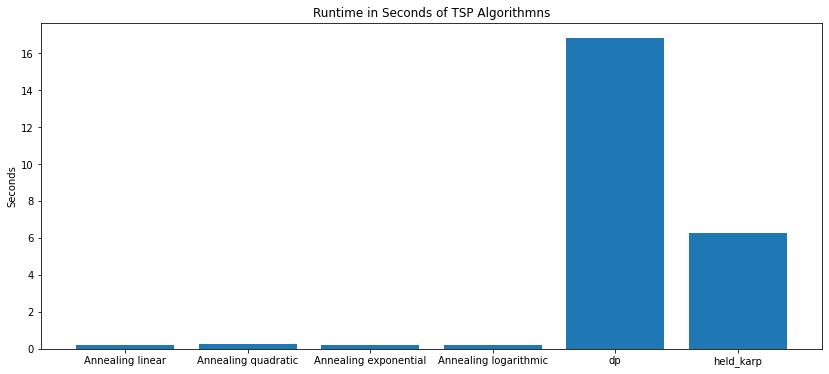

In [91]:
k, v = runtimes.keys(), runtimes.values()
plt.title('Runtime in Seconds of TSP Algorithmns')
plt.ylabel('Seconds')
plt.rcParams["figure.figsize"] = (20,6)
plt.bar(k, v)

In [96]:
runtimes

{'Annealing linear': 0.2264711856842041,
 'Annealing quadratic': 0.2571418285369873,
 'Annealing exponential': 0.20830678939819336,
 'Annealing logarithmic': 0.22355365753173828,
 'dp': 16.803935050964355,
 'held_karp': 6.262645483016968}

## Cost Analysis

In [92]:
hk_total

1112

In [93]:
sa_total

{'linear': 1322, 'quadratic': 1184, 'exponential': 1246, 'logarithmic': 1330}

In [94]:
sa_total['held karp'] = hk_total

<BarContainer object of 5 artists>

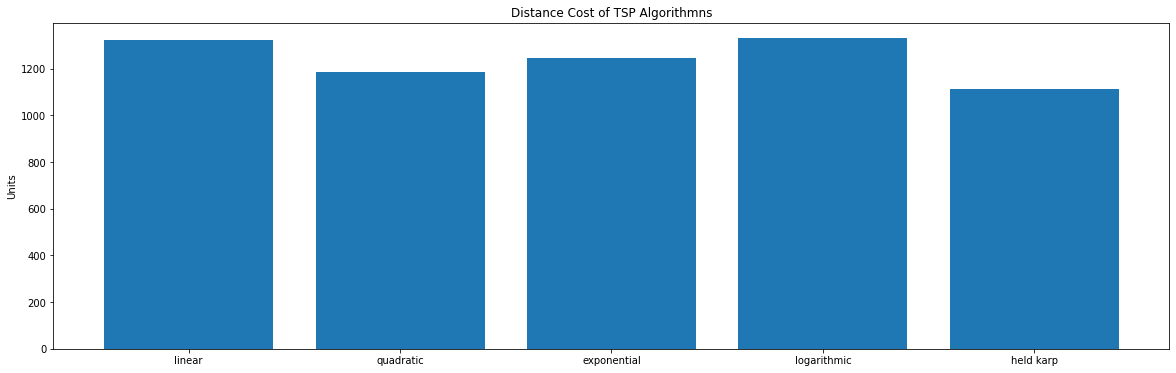

In [95]:
k, v = sa_total.keys(), sa_total.values()
plt.title('Distance Cost of TSP Algorithmns')
plt.ylabel('Units')
plt.rcParams["figure.figsize"] = (14,6)
plt.bar(k, v)